In [6]:
import psycopg2
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import ast
import shapefile
import matplotlib.pyplot as plt
import seaborn as sns


t1 = time.time()


conn = psycopg2.connect("dbname=postgres user=postgres password = ervin2510 host = localhost ")
cursor = conn.cursor()


cursor.execute("Select * FROM calls_311 WHERE created_date > '2018-12-31 23:59:59'")
columns = [column[0] for column in cursor.description]

temp = cursor.fetchall()

temp =[tuple(temp[i]) for i in range(0,len(temp))]

calls_311 = pd.DataFrame(temp,columns=columns)

t2 = time.time()
print(t2-t1)

728.4599776268005


In [4]:
# Data cleaning
calls_311_2 = calls_311[['unique_key',
 'created_date',
 'closed_date',
 'agency',
 'agency_name',
 'complaint_type',
 'descriptor',
 'location_type',
 'incident_zip',
 'incident_address',
 'city',
 'facility_type',
 'status',
 'due_date',
 'resolution_description',
 'resolution_action_updated_date',
 'borough',
 'latitude',
 'longitude']]

# get only the complaints that have to do with rodents
rodents = calls_311_2[calls_311_2['complaint_type'] == 'Rodent']

# change created date from string to datetime
rodents['created_date'] = pd.to_datetime(rodents['created_date'],format='%Y-%m-%d %H:%M:%S')

# change the latitude and longitude columns from strings to floats

rodents['latitude'] = rodents['latitude'].astype(float)

rodents['longitude'] = rodents['longitude'].astype(float)

# how to get rid of all the null geolocation data
rodents_1 = rodents[~((rodents['latitude'].isnull()) &(rodents['latitude'].isnull()))]

# how to turn the rodents df into a geodf
rodents_2 =gpd.GeoDataFrame(
    rodents_1, geometry=gpd.points_from_xy(rodents_1.longitude, rodents_1.latitude))

# get the boundaries of nyc
fp = r'C:\Users\ekallfa\Google Drive\Python experiments\data\Borough Boundaries\geo_export_1db06e5e-af0a-4c79-a621-730205a7c037.shp'
nyc_shape = gpd.read_file(fp)

fp_1 = r'C:\Users\ekallfa\Google Drive\Python experiments\data\2010 Census Tracts\geo_export_aecd6b23-5411-415f-89a1-b6dedb0a2bbb.shp'
nyc_census_tracks = gpd.read_file(fp_1)

rodents_census_tracks = gpd.sjoin(nyc_census_tracks,rodents_2, how ='left', op = 'intersects')
rodents_census_tracks['unique_id'] = rodents_census_tracks['ct2010'] + rodents_census_tracks['boro_name']
# this smaller df was created so that I can get the geometry data in the rodent count df
# boro_ct201 is the unique id for the tracts
nyc_census_tracks_2 = nyc_census_tracks[['boro_ct201','shape_area','shape_leng','geometry']]

# I created this so that I can get a df by using groupby that has the number of calls by census tract, and that it can be
# joined to the nyc_census_tracks_2 in order to get the polygon data
# Geopandas/geoplot does not allow to group by geometry
rodents_census_tracks_3 =rodents_census_tracks[['boro_ct201','unique_key']]
rodents_census_tracks_4 = rodents_census_tracks_3.groupby(['boro_ct201'], as_index = False).count()


rodents_census_tracks_5 = pd.merge(nyc_census_tracks_2,rodents_census_tracks_4, how = 'left', on = 'boro_ct201')

#this is used to create the distribution by income data
# the link to income indicator file
nyc_income = pd.read_csv(r'C:\Users\ekallfa\Google Drive\Python experiments\data\nys_socioeconomic_indicators\ACSDP5Y2017.DP03_data_with_overlays_2019-11-29T145324.csv')

nyc_income_2 = nyc_income[['id','Geographic Area Name','Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households!!Mean household income (dollars)']]

nyc_income_2.rename(columns={'Geographic Area Name':'area','Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households!!Mean household income (dollars)':'mean_household_income'}, inplace = True)

#this gives me only the NYC census tracts 
lst = ['Richmond','New York County','Queens','Kings','Bronx']
nyc_income_3 = nyc_income_2[nyc_income_2['area'].str.contains('|'.join(lst))]
nyc_income_3['id_2'] = nyc_income_3['id'].str[-6:]

#some of the ctlabels contain a .xx number (such as 170.09)
#nyc_income_3['ctlabel'] = nyc_income_3['area'].str.extract(r'((\d+)(.\d{2})?)')

nyc_income_3['boro_name'] = nyc_income_3['area'].str.extract(r'(([a-zA-Z]+)?\s[a-zA-Z]+\sCounty)')[0].str.replace('County','',regex = True)

nyc_income_3['boro_name']= nyc_income_3['boro_name'].str.strip()

boros = {'Kings':'Brooklyn','Richmond':'Staten Island','New York':'Manhattan'}

for i in boros:
    nyc_income_3['boro_name'].replace(i,boros[i],inplace = True)

# the only unique id that I was able to find is the last 6 digits of the id column plus the boro name
nyc_income_3['unique_id'] = nyc_income_3['id_2'] + nyc_income_3['boro_name']


# this gives me only the mean_household_income and the unique_id to join with the rest of the geo data
nyc_income_3.drop(['id_2','boro_name','id','area'], axis = 1,  inplace = True)


# I need to create this in order to get the tracts geolocations for the income display
nyc_census_tracks_3 = nyc_census_tracks[['ct2010','boro_name','shape_area','shape_leng','geometry']]

nyc_census_tracks_3['unique_id'] = nyc_census_tracks_3['ct2010'] + nyc_census_tracks_3['boro_name']

nyc_census_tracks_3.drop(['ct2010','boro_name'], axis = 1, inplace = True)

nyc_income_by_ctract = pd.merge(nyc_census_tracks_3,nyc_income_3, how = 'left', on = 'unique_id')
nyc_income_by_ctract['mean_household_income'].replace('-',0,inplace = True)
nyc_income_by_ctract['mean_household_income'].replace('N',0,inplace = True)
nyc_income_by_ctract['mean_household_income'] = nyc_income_by_ctract['mean_household_income'].astype(float)


############################################################################################################################################################################################
# this is used to create the distribution of the population in NYC
# for this I have used data from the American Fact finder to determine the population of each census tack in NYC
nyc_pop = pd.read_csv(r'C:\Users\ekallfa\Google Drive\Python experiments\data\nys_population_count\ACS_17_5YR_DP05_with_ann.csv')


nyc_pop_2 = nyc_pop[['Id','Geography','Estimate; SEX AND AGE - Total population']]

nyc_pop_2.rename(columns={'Geography':'area','Estimate; SEX AND AGE - Total population':'pop_size', 'Id':'id'}, inplace = True)


#this gives me only the NYC census tracts 
lst = ['Richmond','New York County','Queens','Kings','Bronx']
nyc_pop_3 = nyc_pop_2[nyc_pop_2['area'].str.contains('|'.join(lst))]
nyc_pop_3['id_2'] = nyc_pop_3['id'].str[-6:]

#some of the ctlabels contain a .xx number (such as 170.09)
#nyc_income_3['ctlabel'] = nyc_income_3['area'].str.extract(r'((\d+)(.\d{2})?)')

nyc_pop_3['boro_name'] = nyc_pop_3['area'].str.extract(r'(([a-zA-Z]+)?\s[a-zA-Z]+\sCounty)')[0].str.replace('County','',regex = True)

nyc_pop_3['boro_name']= nyc_pop_3['boro_name'].str.strip()

boros = {'Kings':'Brooklyn','Richmond':'Staten Island','New York':'Manhattan'}

for i in boros:
    nyc_pop_3['boro_name'].replace(i,boros[i],inplace = True)

# the only unique id that I was able to find is the last 6 digits of the id column plus the boro name
nyc_pop_3['unique_id'] = nyc_pop_3['id_2'] + nyc_pop_3['boro_name']


# this gives me only the pop_size and the unique_id to join with the rest of the geo data
nyc_pop_3.drop(['id_2','boro_name','id','area'], axis = 1,  inplace = True)

#the 0s were causing me problems displaying the data
nyc_pop_3['pop_size'] = nyc_pop_3['pop_size'].astype(float)
nyc_pop_3 = nyc_pop_3[nyc_pop_3['pop_size'] >  0]
nyc_pop_3 = nyc_pop_3[pd.notnull(nyc_pop_3['pop_size'])]
nyc_pop_by_ctract = pd.merge(nyc_census_tracks_3,nyc_pop_3, how = 'left', on = 'unique_id')

nyc_pop_by_ctract = nyc_pop_by_ctract[~nyc_pop_by_ctract['pop_size'].isnull()]

#################################################################################################################
# this is intended to measure the population density per track by first finding the area of each tract 
# then dividing the population of the track by the track area

nyc_pop_by_ctract_2 = nyc_pop_by_ctract.copy()

nyc_pop_by_ctract_2 =nyc_pop_by_ctract_2.to_crs({'init': 'epsg:32633'}) #I need to look more into this

#the area_size is in square km.
nyc_pop_by_ctract_2['area_size'] = nyc_pop_by_ctract_2['geometry'].area /10**6

nyc_pop_by_ctract_2['density'] = round(nyc_pop_by_ctract_2['pop_size']/ nyc_pop_by_ctract_2['area_size'], 2)

# when I modified the data to get the area, something changed that did not allow me to project the data on the map
# I had to cread a new geoDF by merging the denisty per tract data with the DF that contains the tract shapes

nyc_pop_by_ctract_3 = pd.merge(nyc_census_tracks_3,nyc_pop_by_ctract_2[['unique_id','density']], how = 'left', on = 'unique_id')

#the merger introduces nulls, so I have to get rid of them
nyc_pop_by_ctract_4 = nyc_pop_by_ctract_3[~pd.isnull(nyc_pop_by_ctract_3['density'])]

#########################################################################################################################################################################
# the population of NYC (nyc opendata source)
nyc_pop = pd.read_json(r'https://data.cityofnewyork.us/resource/swpk-hqdp.json')
nyc_pop_2 = nyc_pop[nyc_pop['year'] == nyc_pop['year'].max()]
nyc_pop_3 = nyc_pop_2.groupby('borough', as_index = False)['population'].sum()

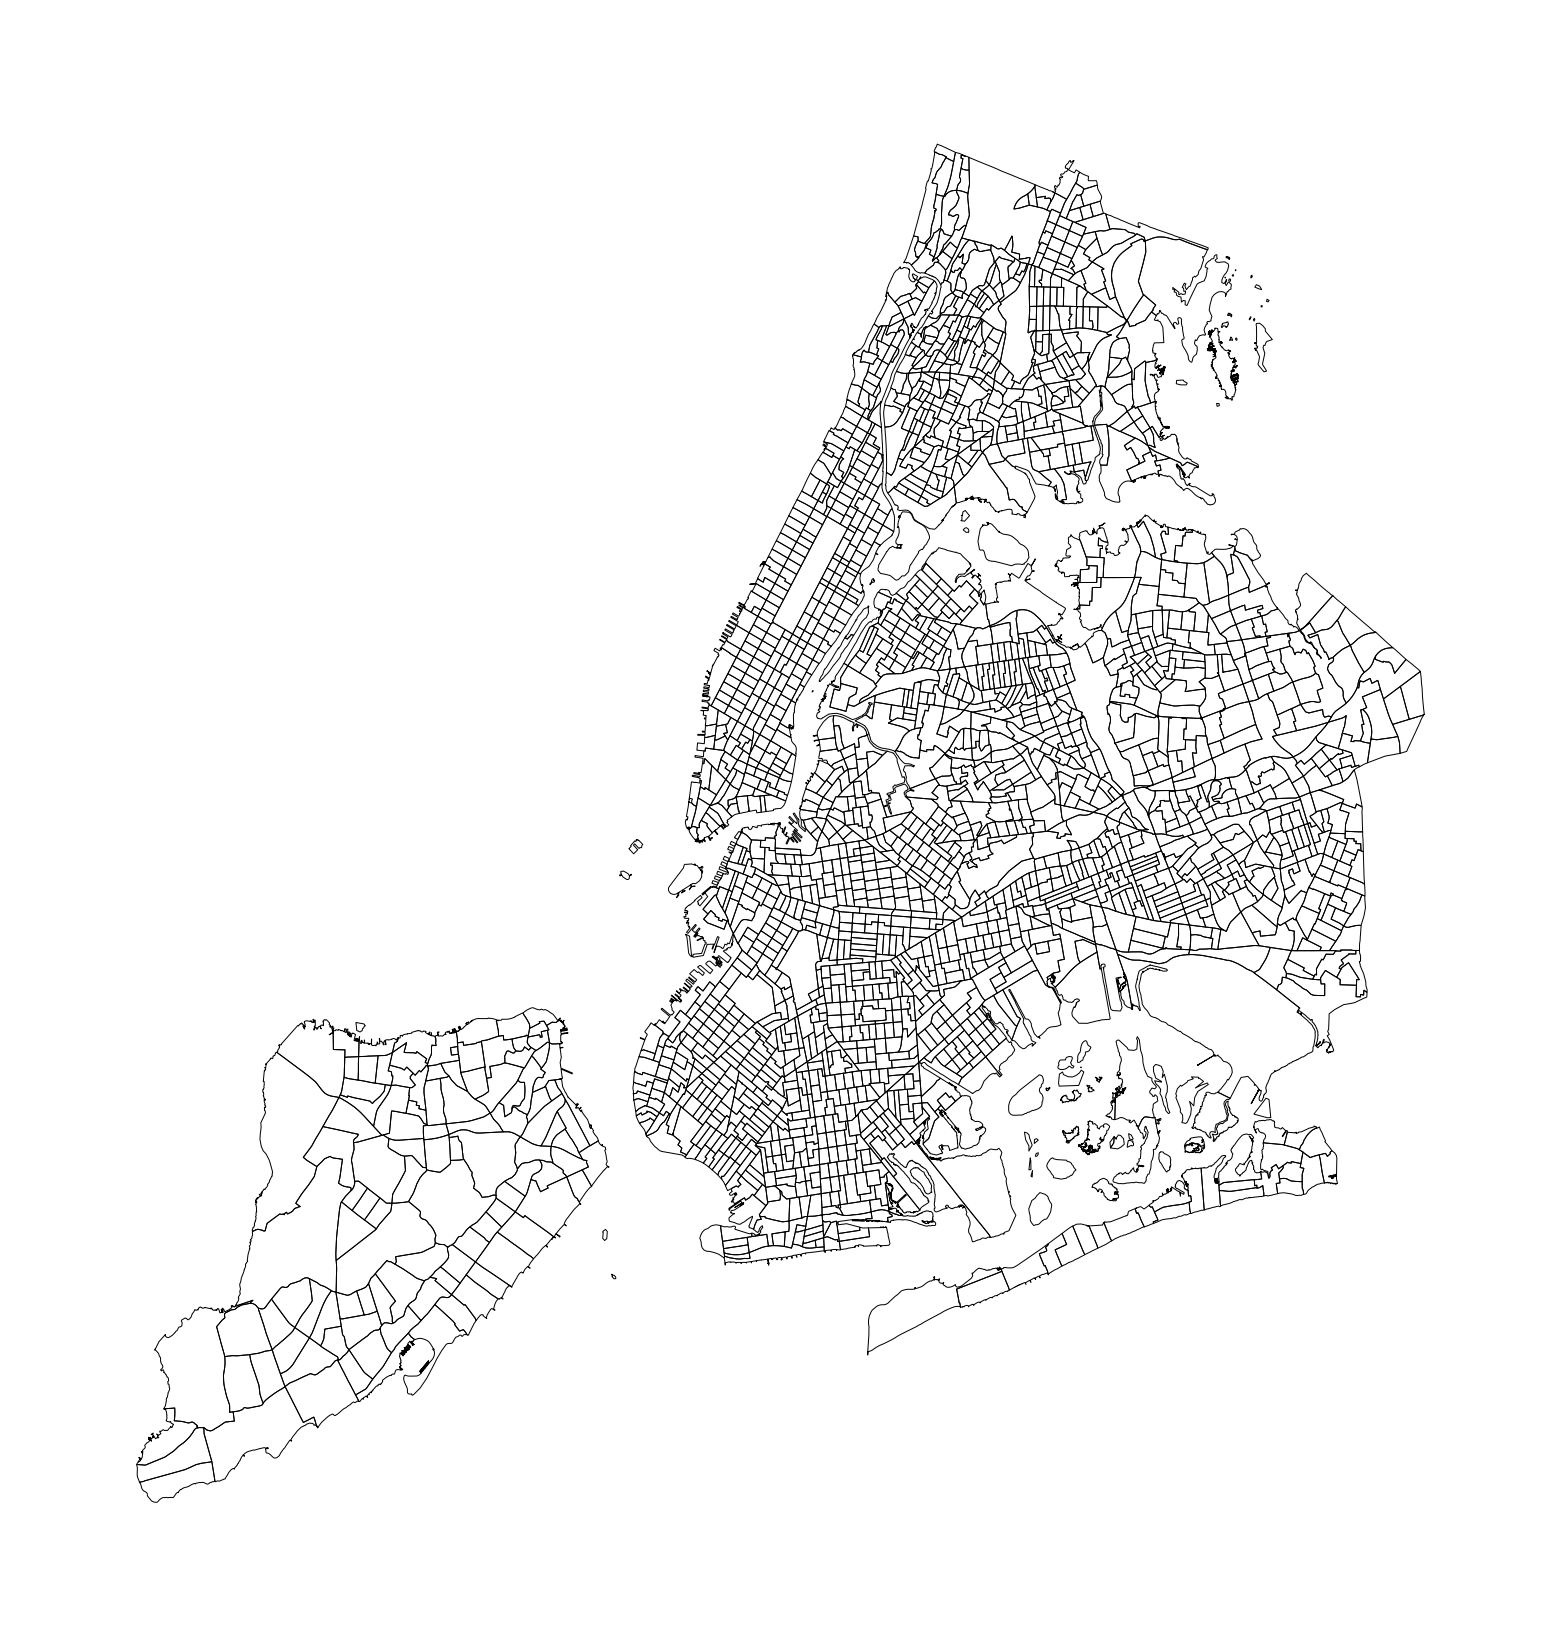

In [6]:
# figsize regulates the size of the figure
gplt.polyplot(nyc_census_tracks, projection=gcrs.AlbersEqualArea(),figsize=(40, 30))

Text(0.5, 1.0, 'NYC Rodent Problem, 2019')

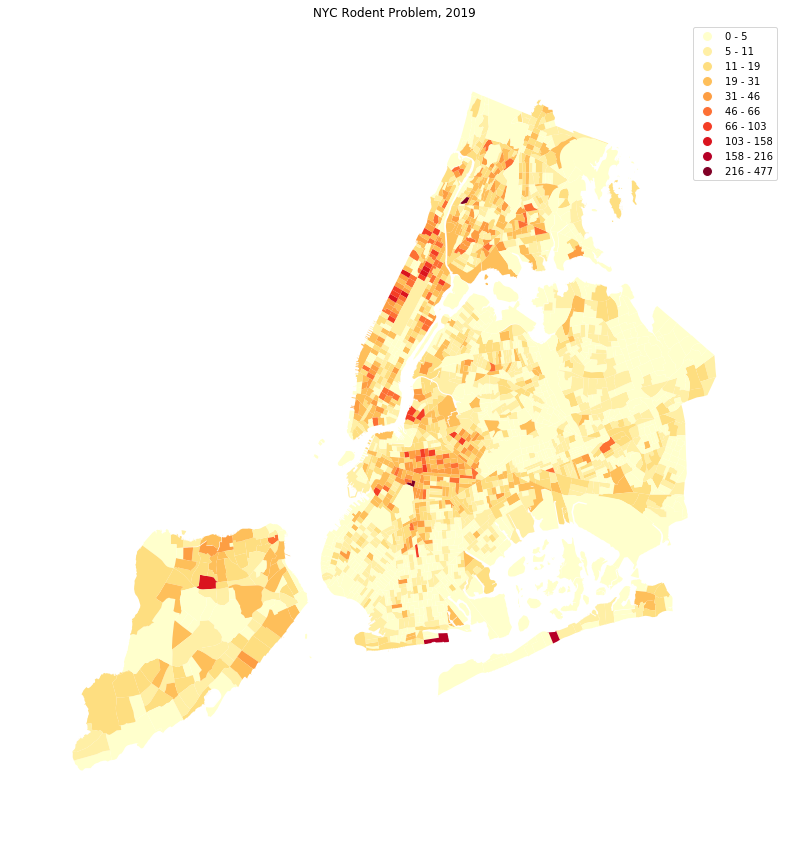

In [5]:

gplt.choropleth(
    rodents_census_tracks_5, hue='unique_key', projection=gcrs.AlbersEqualArea(),
    edgecolor='white', linewidth=0,
    cmap='YlOrRd', k=10, legend=True,
    scheme='FisherJenks', # this determines how the data is aggregated. See this link for more info http://geopandas.org/reference.html
    figsize = (30,15))

plt.title("NYC Rodent Problem, 2019")

Text(0.5, 1.0, 'NYC Mean Household Income, 2017')

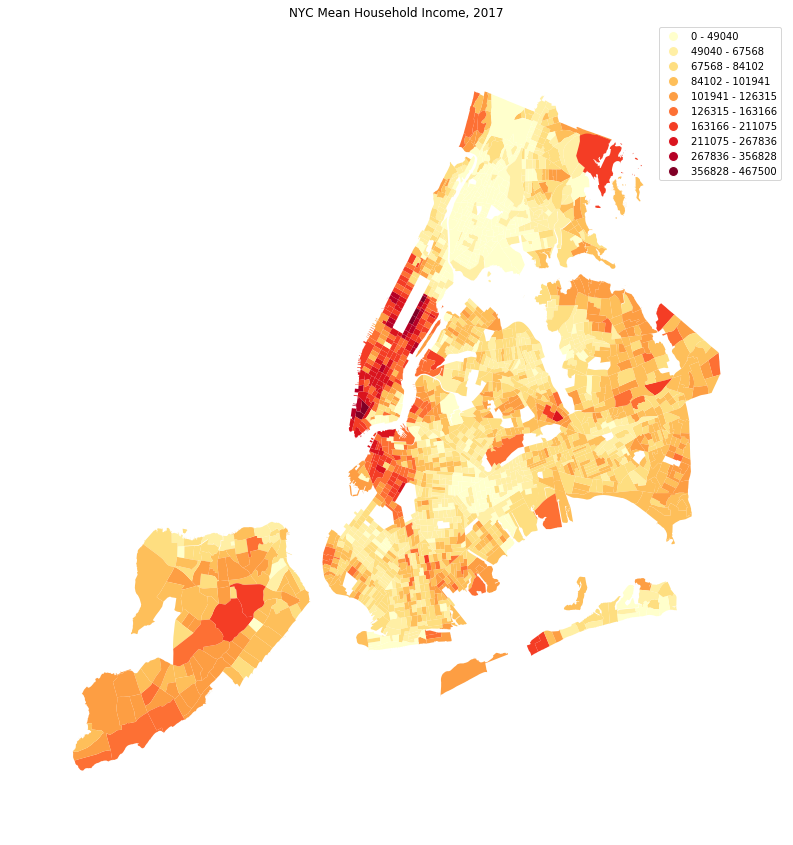

In [8]:

gplt.choropleth(
    nyc_income_by_ctract[nyc_income_by_ctract['mean_household_income'] > 0], hue='mean_household_income', projection=gcrs.AlbersEqualArea(),
    edgecolor='white', linewidth=0,
    cmap='YlOrRd', k=10, legend=True,
    scheme='FisherJenks', # this determines how the data is aggregated. See this link for more info http://geopandas.org/reference.html
    figsize = (30,15))

plt.title("NYC Mean Household Income, 2017")

Text(0.5, 1.0, 'NYC Population By Census Tract, 2017')

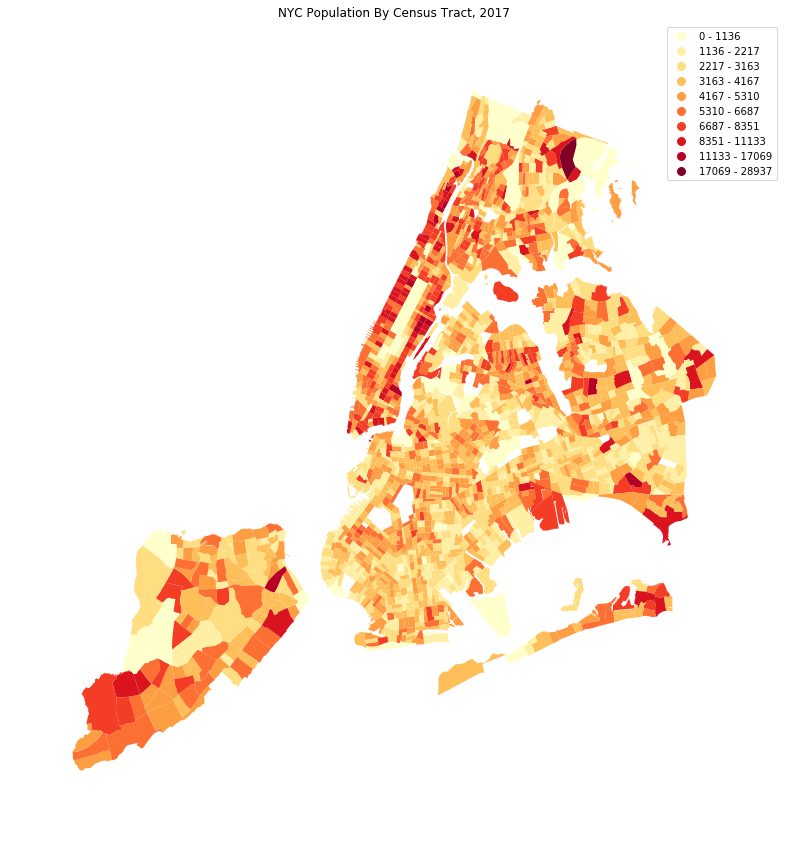

In [10]:

gplt.choropleth(
    nyc_pop_by_ctract, hue='pop_size', projection=gcrs.AlbersEqualArea(),
    edgecolor='white', linewidth=0,
    cmap='YlOrRd', k=10, legend=True,
    scheme='FisherJenks', # this determines how the data is aggregated. See this link for more info http://geopandas.org/reference.html
    figsize = (30,15))

plt.title("NYC Population By Census Tract, 2017")

Text(0.5, 1.0, 'NYC Population Density By Census Tract, 2017')

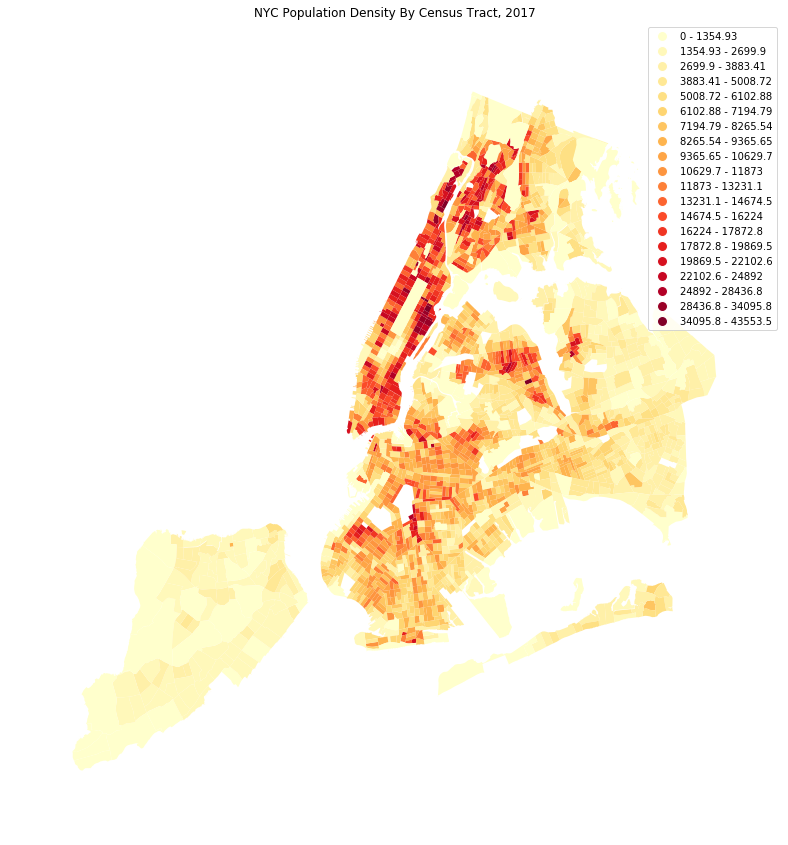

In [34]:
gplt.choropleth(
    nyc_pop_by_ctract_4, hue='density', projection=gcrs.AlbersEqualArea(),
    edgecolor='white', linewidth=0,
    cmap='YlOrRd', k=20, legend=True,
    scheme='FisherJenks', # this determines how the data is aggregated. See this link for more info http://geopandas.org/reference.html
    figsize = (30,15))

plt.title("NYC Population Density By Census Tract, 2017")

Text(0.5, 1.0, 'NYC Rodents Problem, 2019')

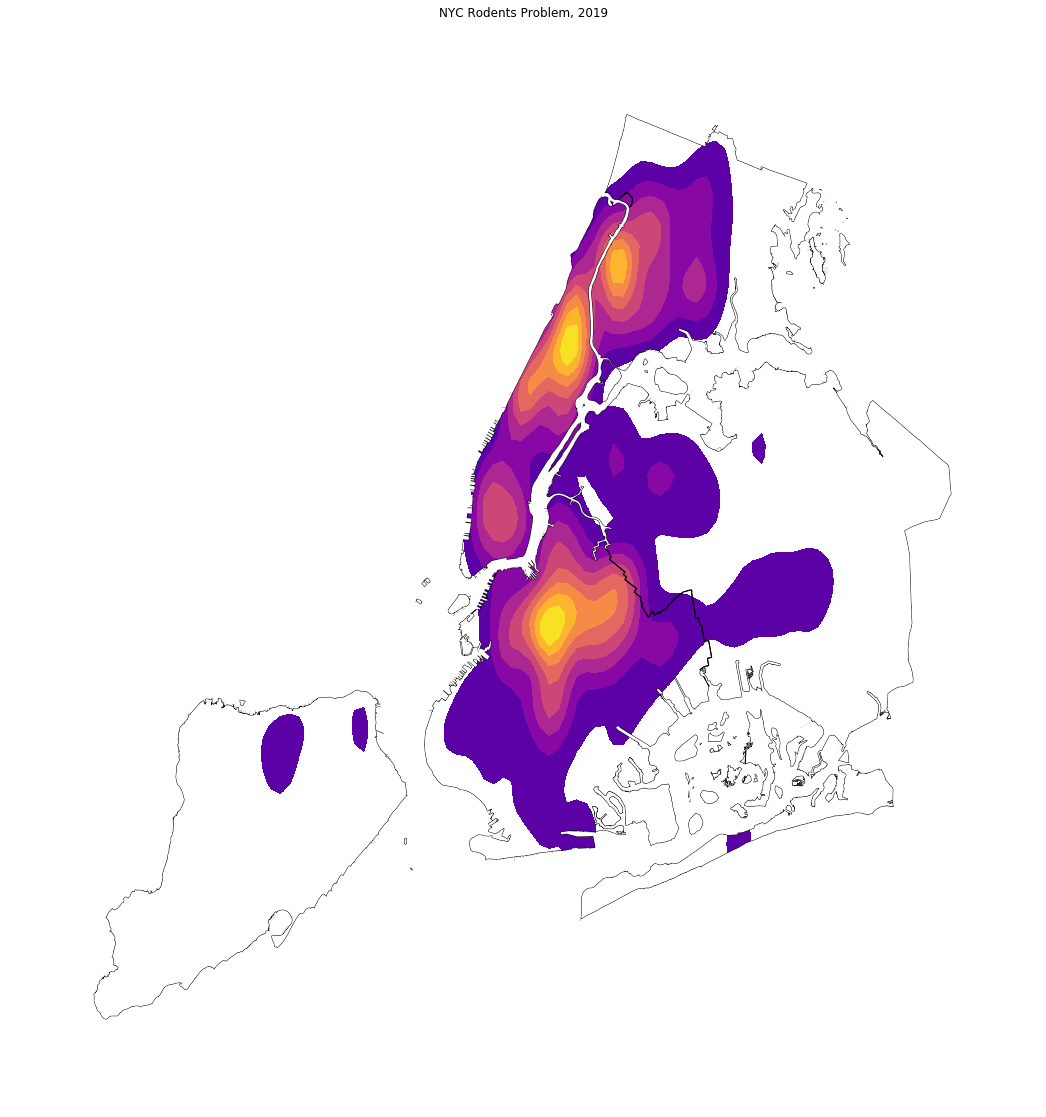

In [7]:
proj = gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059)
fig = plt.figure(figsize=(30,20))
ax = plt.subplot(111, projection=proj)
#ax = gplt.webmap(acc_geoloc, projection=gcrs.WebMercator())

gplt.kdeplot(
    rodents_2,
    cmap='plasma',
    projection=proj,
    shade=True, shade_lowest=False,
    clip=nyc_shape.geometry,
    ax=ax
)

#p = ax.pcolor(acc_geoloc_3, cmap='Greens_r', vmin=0, vmax=200)
gplt.polyplot(nyc_shape, zorder=1, ax=ax)
plt.title("NYC Rodents Problem, 2019")

Text(0.5, 1.0, 'NYC Accidents by Boro, 2018')

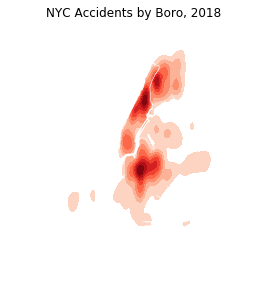

In [10]:
proj = gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059)
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection=proj)

gplt.kdeplot(
    rodents_2,
    cmap='Reds',
    projection=proj,
   shade=True, shade_lowest=False, 
    clip=nyc_shape.geometry,
    ax=ax1
)

gplt.polyplot(nyc_shape, zorder=1, ax=ax)
plt.title("NYC Accidents by Boro, 2018")

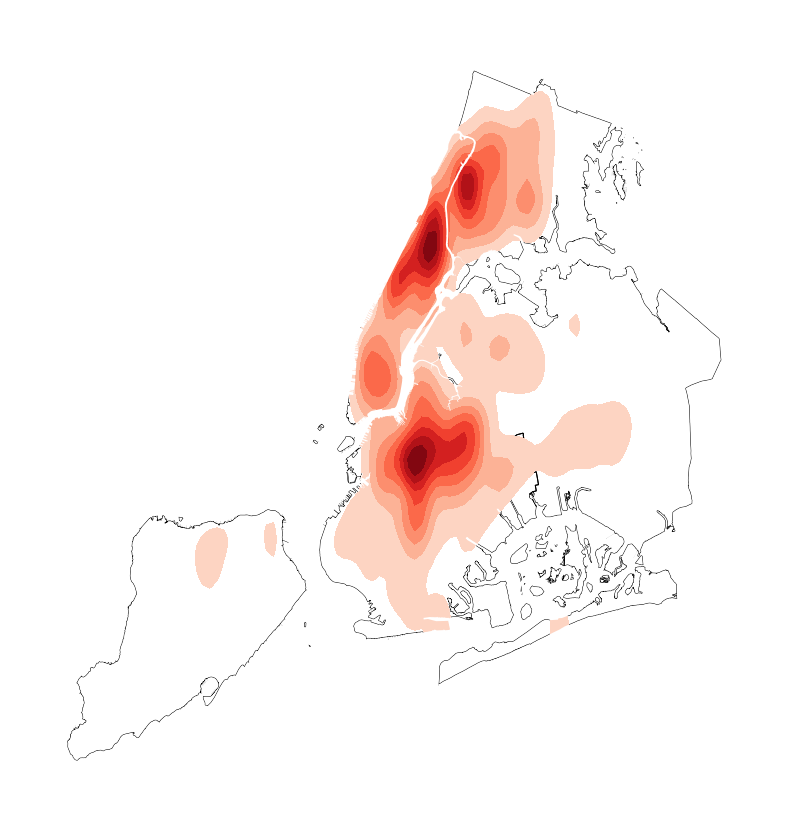

In [14]:
ax = gplt.polyplot(nyc_shape, projection=gcrs.AlbersEqualArea(),figsize = (30,15))
gplt.kdeplot(rodents_2, cmap='Reds', shade=True, clip=nyc_shape, ax=ax)

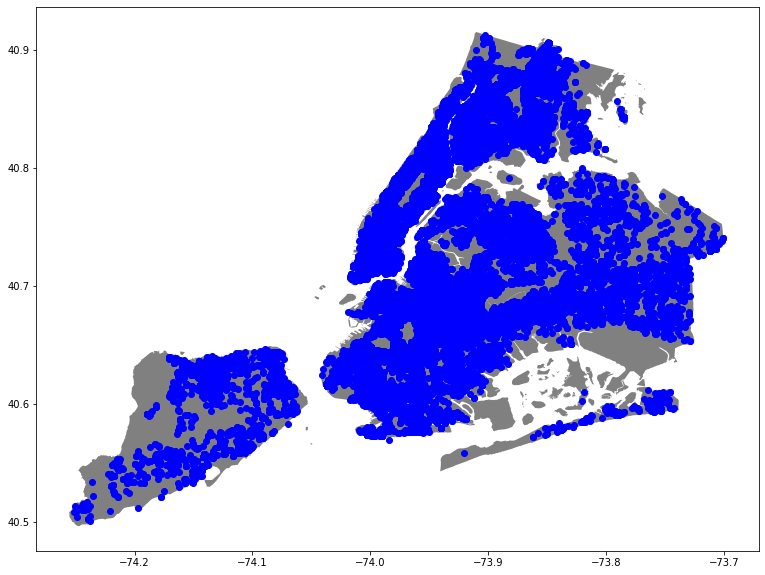

In [12]:
plt.rcParams["figure.figsize"] = [15,10]

ax = nyc_shape.plot(color='gray')


rodents_2.plot(ax=ax, color ='blue')


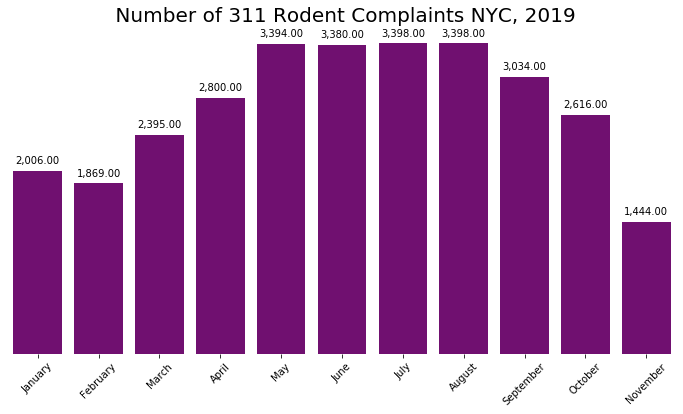

In [96]:
# this was done so that the months in the chart would be sorted chronologically
rodents.sort_values('created_date', inplace = True)

# 311 rodent calls by month 
plt.figure(figsize = (12,6))

# use created_date.dt.month_name to get the name of the month

ax = sns.countplot(x = rodents['created_date'].dt.month_name(), color = 'purple')

    
plt.xticks(rotation = 45)
plt.title(' Number of 311 Rodent Complaints NYC, 2019', fontsize = 20)

#I do not think that naming the axes will provide any additional info
# the info is already in the title
plt.xlabel('')
plt.ylabel('')

# this puts the number of call on the bars
# if I get rid of the '.2f', the numbers will show as integers, not as floats
# the "," in front of .2f adds the thousand separators 
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
# this gets rid of the y-axis    
ax.get_yaxis().set_ticks([])

# these get rid of the borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
    

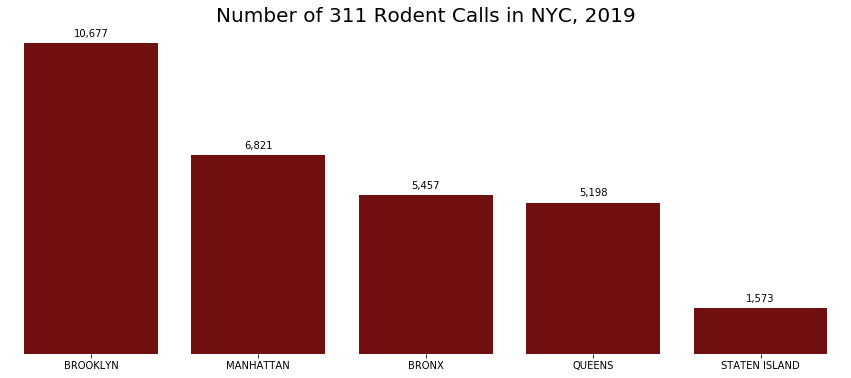

In [93]:
#####################################################################################################################################################################
# displaying the calls by boro

plt.figure(figsize =(15,6))

ax = sns.countplot(x = rodents['borough'][rodents['borough'] != 'Unspecified'], color = 'maroon')

plt.title('Number of 311 Rodent Calls in NYC, 2019', fontsize = 20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.get_yaxis().set_ticks([])

plt.ylabel('')
plt.xlabel('')

# the ',' in format adds the commas. COOL feature
for p in ax.patches:
    ax.annotate(format(p.get_height(),','), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

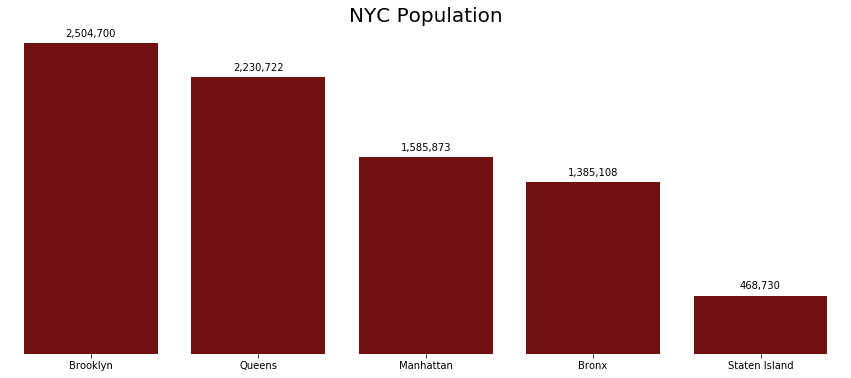

In [95]:
#####################################################################################################################################################################
# displaying the nyc population by boro
nyc_pop_3.sort_values('population', ascending = False, inplace = True)
plt.figure(figsize =(15,6))

ax = sns.barplot(x = nyc_pop_3['borough'],y = nyc_pop_3['population'], color = 'maroon')

plt.title('NYC Population', fontsize = 20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.get_yaxis().set_ticks([])

plt.ylabel('')
plt.xlabel('')

# '.0f' turned the floats into integers
for p in ax.patches:
    ax.annotate(format(p.get_height(),(',.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In [22]:
#this is how you list all the dataframes in the current notebook
%who GeoDataFrame

nyc_census_tracks	 nyc_census_tracks_2	 nyc_census_tracks_3	 nyc_income_by_ctract	 nyc_pop_by_ctract	 nyc_pop_by_ctract_2	 nyc_pop_by_ctract_3	 nyc_pop_by_ctract_4	 nyc_shape	 
rodents_2	 rodents_census_tracks	 rodents_census_tracks_5	 


In [29]:
rodent_calls_tract = rodents_census_tracks[['unique_key','unique_id']].groupby('unique_id', as_index = False).count()

In [24]:
nyc_pop_by_ctract_4.head(2)

,shape_area,shape_leng,geometry,unique_id,density
0,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",000900Staten Island,3233.61
1,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",009800Manhattan,17803.54


In [32]:
# this df lists the number of calls and tract density by tract
density_call_tract = pd.merge(rodent_calls_tract, nyc_pop_by_ctract_4[['unique_id','density']], how = 'inner', on ='unique_id')

density_call_tract.rename(columns ={'unique_key': 'no_calls'}, inplace = True)

density_call_tract.head()

,unique_id,no_calls,density
0,000100Bronx,1,1886.50
1,000100Brooklyn,12,8477.44
2,000100Queens,14,2828.35
3,000200Bronx,30,4674.88
4,000200Brooklyn,22,2345.57


In [35]:
density_call_tract['density'].dtype

dtype('float64')

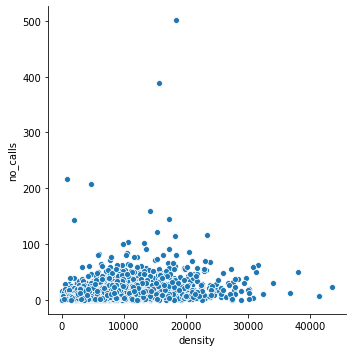

In [40]:
sns.relplot(x="density", y= "no_calls", data= density_call_tract)



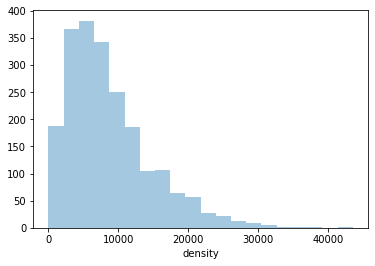

In [43]:
sns.distplot(density_call_tract['density'],kde=False, bins=20)

In [45]:
density_call_tract['density'].describe()

count     2127.000000
mean      8667.548213
std       6079.776886
min          0.480000
25%       4212.660000
50%       7350.970000
75%      11574.300000
max      43553.460000
Name: density, dtype: float64